In [2]:
import tensorflow as tf

tf.__version__

'2.17.0'

In [ ]:
# 텐서플로우 버전과 동일하게 tensorflow-text 설치해야함
!pip install tensorflow-text==2.17.0

# 라이브러리

In [ ]:
# 파이썬 표준 라이브러리
import csv
import random
import string
import re
from urllib import request

# 파이썬 서드파티 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sentencepiece as spm
import tensorflow_text as tf_text
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.utils import pad_sequences

# 클래스

## 위치 임베딩

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length: int, input_dim: int, output_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens *= tf.math.sqrt(tf.cast(self.output_dim, tf.float32))
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
        })
        return config

## 인코더 레이어

In [ ]:
class EncoderLayer(layers.Layer):
    def __init__(self, embed_dim: int, dense_dim: int, num_heads: int, dropout_rate: float=0.2, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.dense_proj = keras.Sequential(
            [layers.Dense(units=dense_dim, activation="relu"),
             layers.Dense(units=embed_dim),
             layers.Dropout(rate=dropout_rate)]
        )
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-7) # 16비트 연산을 지원하지 않는 GPU의 경우 오류가 나므로 32비트 연산으로 바꾸기 위해 설정
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-7)

    def call(self, inputs, encoder_pad_mask):
        attention_output = self.attention(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=encoder_pad_mask)
        proj_input = self.layernorm_1(layers.Add()([inputs, attention_output])) # inputs + attention_output은 mask 전파가 안됨
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(layers.Add()([proj_input, proj_output])) # proj_input + proj_outputt은 mask 전파가 안됨

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
            "dropout_rate": self.dropout_rate
        })
        return config

## 인코더

In [ ]:
class Encoder(layers.Layer):
    def __init__(self, *, num_layers, sequence_length, input_dim, embed_dim,
                 dense_dim, num_heads, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.pos_embedding = PositionalEmbedding(sequence_length=sequence_length,
                                                 input_dim=input_dim,
                                                 output_dim=embed_dim,
                                                 name="Encoder_PositionalEmbedding")
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

        self.enc_layers = [
                            EncoderLayer(embed_dim=embed_dim,
                                        dense_dim=dense_dim,
                                         num_heads=num_heads,
                                        dropout_rate=dropout_rate)
                            for _ in range(num_layers)]

    def call(self, inputs, encoder_pad_mask):
        # inputs -> Token-IDs Shape: (batch, encoder_sequence_length)
        inputs = self.pos_embedding(inputs)  # Shape: (batch_size, encoder_sequence_length, embed_dim)
        inputs = self.dropout(inputs)

        for i in range(self.num_layers):
            inputs = self.enc_layers[i](inputs=inputs, encoder_pad_mask=encoder_pad_mask)

        return inputs  # Shape: (batch_size, encoder_sequence_length, embed_dim)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_layers": self.num_layers,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
            "dropout_rate": self.dropout_rate
        })
        return config

## 디코더 레이어

In [ ]:
class DecoderLayer(layers.Layer):
    def __init__(self, embed_dim: int, dense_dim: int, num_heads: int, dropout_rate: float=0.2, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.dense_proj = keras.Sequential([
            layers.Dense(units=dense_dim, activation="relu"),
            layers.Dense(units=embed_dim),
            layers.Dropout(rate=dropout_rate)
        ])
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-7) # 16비트 연산을 지원하지 않는 GPU의 경우 오류가 나므로 32비트 연산으로 바꾸기 위해 설정
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-7)
        self.layernorm_3 = layers.LayerNormalization(epsilon=1e-7)

    def call(self, inputs, encoder_outputs,
             encoder_pad_mask, decoder_pad_mask,
             causal_mask):
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=decoder_pad_mask & causal_mask)
        attention_output_1 = self.layernorm_1(layers.Add()([inputs, attention_output_1])) # inputs + attention_output_1는 mask 전파가 안됨
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=encoder_pad_mask
        )
        attention_output_2 = self.layernorm_2(layers.Add()([attention_output_1, attention_output_2])) # attention_output_1 + attention_output_2는 mask 전파가 안됨
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(layers.Add()([attention_output_2, proj_output])) # attention_output_2 + proj_output는 mask 전파가 안됨

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
            "dropout_rate": self.dropout_rate
        })
        return config

## 디코더

In [ ]:
class Decoder(layers.Layer):
    def __init__(self, *, num_layers, sequence_length, input_dim, embed_dim,
                 dense_dim, num_heads, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.pos_embedding = PositionalEmbedding(sequence_length=sequence_length,
                                                 input_dim=input_dim,
                                                output_dim=embed_dim,
                                                 name="Decoder_PositionalEmbedding")
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

        self.dec_layers = [
                            DecoderLayer(embed_dim=embed_dim, dense_dim=dense_dim,
                                         num_heads=num_heads, dropout_rate=dropout_rate)
                            for _ in range(num_layers)]

    def call(self, inputs, encoder_outputs,
             encoder_pad_mask, decoder_pad_mask,
             causal_mask):
        # inputs -> Token-IDs Shape: (batch, decoder_sequence_length)
        inputs = self.pos_embedding(inputs)  # Shape: (batch_size, decoder_sequence_length, embed_dim)
        inputs = self.dropout(inputs)

        for i in range(self.num_layers):
            inputs  = self.dec_layers[i](inputs=inputs, encoder_outputs=encoder_outputs,
                                         encoder_pad_mask=encoder_pad_mask, decoder_pad_mask=decoder_pad_mask,
                                         causal_mask=causal_mask)

        return inputs # Shape: (batch_size, decoder_sequence_length, embed_dim)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_layers": self.num_layers,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
            "dropout_rate": self.dropout_rate
        })
        return config

## 트랜스포머

In [ ]:
class Transformer(keras.Model):
    def __init__(self, *, num_layers, encoder_sequence_length, decoder_sequence_length, source_vocab_size, target_vocab_size, embed_dim,
                 dense_dim, num_heads, dropout_rate):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, sequence_length=encoder_sequence_length, input_dim=source_vocab_size, embed_dim=embed_dim,
                              dense_dim=dense_dim, num_heads=num_heads, dropout_rate=dropout_rate)
        self.decoder = Decoder(num_layers=num_layers, sequence_length=decoder_sequence_length, input_dim=target_vocab_size, embed_dim=embed_dim,
                              dense_dim=dense_dim, num_heads=num_heads, dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(units=target_vocab_size)

    def call(self, inputs):
        encoder_inputs, decoder_inputs = inputs
        encoder_pad_mask = tf.math.not_equal(encoder_inputs, 0)[:, tf.newaxis]
        decoder_pad_mask = tf.math.not_equal(decoder_inputs, 0)[:, tf.newaxis]

        decoder_sequence_length = tf.shape(decoder_inputs)[1]
        causal_mask = tf.linalg.band_part(tf.ones((decoder_sequence_length, decoder_sequence_length), tf.bool), -1, 0)

        encoder_inputs = self.encoder(inputs=encoder_inputs, encoder_pad_mask=encoder_pad_mask)  # Shape: (batch_size, encoder_sequence_length, embed_dim)
        decoder_inputs = self.decoder(inputs=decoder_inputs, encoder_outputs=encoder_inputs,
                                      encoder_pad_mask=encoder_pad_mask, decoder_pad_mask=decoder_pad_mask,
                                      causal_mask=causal_mask)  # Shape: (batch_size, decoder_sequence_length, embed_dim)

        logits = self.final_layer(decoder_inputs)  # Shape: (batch_size, decoder_sequence_length, target_vocab_size)

        try:
            # losses/metrics가 커지지 않게 keras_mask를 제거
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

## 1사이클 스케줄링

In [ ]:
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, embed_dim, warmup_steps=4000):
        super().__init__()
        self.embed_dim = embed_dim
        self.embed_dim = tf.cast(self.embed_dim, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.embed_dim) * tf.math.minimum(arg1, arg2)

## 번역기

In [ ]:
class Translator(tf.Module):
    # 데이터 전처리 함수
    @staticmethod
    def preprocess_text(text_: str, max_repeat: int=2) -> str:
        """텍스트 문자열 중 일부 규칙적인 부분을 전처리 하는 함수

        Args:
            text_: 텍스트 문자열 -> str
            max_repeat: 똑같은 문자열이 연속해서 반복할 수 있는 최대 횟수 -> int

        Returns:
            text_: 전처리 된 텍스트 문자열 -> str
        """

        text_ = text_.lower()
        text_ = re.sub(pattern=r"…", repl=r"...", string=text_)
        text_ = re.sub(pattern=rf"[^\w\s{string.punctuation}]", repl=r"", string=text_)
        text_ = re.sub(pattern=r"(?P<s>\?|\!)(?P=s)*", repl=r"\g<s>", string=text_) # ? 또는 !가 2번 이상 연속되면 1개로 수정
        text_ = re.sub(pattern=r"(?P<char>[^\d.])(?P=char){" + str(max_repeat - 1) + r",}", repl=r"\g<char>" * max_repeat, string=text_) # 점 또는 숫자가 아닌 똑같은 문자열이 repeat번 이상 연속되면 repeat만큼으로 수정
        text_ = re.sub(pattern=r"\.[\s\.]+\.", repl=lambda x: x.group().replace(" ", ""), string=text_) # . . .... . 이런 경우 수정
        text_ = re.sub(r"\.{3,}(?=[\w\s" + f"{string.punctuation}" + r"])", r"...", text_) # .......[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~] 줄이기
        text_ = re.sub(pattern=r"(?P<p>\.{2,})(?P<s>\w)", repl=r"\g<p> \g<s>", string=text_) # 띄어쓰기 교정
        text_ = re.sub(pattern=r"\s+(?P<p>\.+)", repl=r"\g<p>", string=text_) # 띄어쓰기 교정
        text_ = re.sub(pattern=r"\s+", repl=" ", string=text_)

        # 영어 축약형을 풀기
        # 's 축약은 is / has 또는 아예 소유격으로 가능해서 제외
        # 'd 축약은 had / would / could 등으로 가능해서 제외
        # 'll 축약은 shall / will로 가능해서 제외
        text_ = re.sub(pattern=r"\bi'm\b", repl=r"i am", string=text_)
        text_ = re.sub(pattern=r"\b(?P<subj>you|we|they|there|who|when|where|what|how|why)'re\b", repl=r"\g<subj> are", string=text_)
        text_ = re.sub(pattern=r"\b(?P<verb>is|are|was|were|do|does|did|have|has|had|must|should|may|might|could|would|ought|dare|need)n't\b", repl=r"\g<verb> not", string=text_)
        text_ = re.sub(pattern=r"\bwon't\b", repl=r"will not", string=text_)
        text_ = re.sub(pattern=r"\bcan't\b", repl=r"can not", string=text_)
        text_ = re.sub(pattern=r"\bshan't\b", repl=r"shall not", string=text_)
        text_ = re.sub(pattern=r"\b(?P<subj>i|you|they|we|should|could|would|must|not)'ve\b", repl=r"\g<subj> have", string=text_)

        text_ = text_.strip()
        return text_

    # tensorflow의 바이트 문자열 데이터 전처리 함수
    def tf_preprocess_text(text_: tf.string, max_repeat: int=2) -> tf.string:
        """텍스트 문자열 중 일부 규칙적인 부분을 전처리 하는 함수

        Args:
            text_: 바이트 문자열 -> tf.string
            max_repeat: 똑같은 문자열이 연속해서 반복할 수 있는 최대 횟수 -> int

        Returns:
            text_: 전처리 된 바이트 문자열 -> tf.string
        """

        text_ = tf.strings.lower(input=text_)
        text_ = tf.strings.regex_replace(input=text_, pattern=r"…", rewrite=r"...")
        text_ = tf.strings.regex_replace(input=text_, pattern=rf"[^\w\s{string.punctuation}]", rewrite=r"")
        text_ = tf.strings.regex_replace(input=text_, pattern=r"\?+", rewrite=r"?") # ?가 2번 이상 연속되면 ?로 수정
        text_ = tf.strings.regex_replace(input=text_, pattern=r"\!+", rewrite=r"!") # !가 2번 이상 연속되면 !로 수정

        # 점 또는 숫자가 아닌 똑같은 문자열이 repeat번 이상 연속되면 repeat만큼으로 수정
        stacks = tf.TensorArray(dtype=tf.string, size=0, dynamic_size=True)
        for s in tf.strings.bytes_split(text_):
            if stacks.size() >= max_repeat:
                if tf.strings.regex_full_match(input=s, pattern=r"[^\d.]"):
                    back_s = stacks.gather(indices=tf.range(start=stacks.size() - max_repeat, limit=stacks.size(), delta=1))
                    if tf.math.reduce_all(back_s == s):
                        continue

            stacks = stacks.write(stacks.size(), s)

        text_ = tf.strings.reduce_join(inputs=stacks.stack())

        # . . .... . 이런 경우 .......으로 수정
        text_ += tf.constant("t", dtype=tf.string) # 마지막이 [\s.]으로 끝나면은 dot_stacks에 남아있는 바이트 문자열들이 버려지게되므로 종료 바이트 문자열 "t"를 추가
        stacks = tf.TensorArray(dtype=tf.string, size=0, dynamic_size=True)
        dot_stacks = tf.TensorArray(dtype=tf.string, size=0, dynamic_size=True)

        for s in tf.strings.bytes_split(text_):
            if tf.strings.regex_full_match(input=s, pattern=r"[\s.]"):
                dot_stacks = dot_stacks.write(dot_stacks.size(), s)
            else:
                dot_ = tf.strings.reduce_join(inputs=dot_stacks.stack())
                only_dot_ = tf.strings.regex_replace(input=dot_, pattern=r"\s", rewrite="")
                dot_splits = tf.strings.bytes_split(dot_)

                # 최초의 .앞에 있는 " "들을 추가
                for c in dot_splits:
                    if tf.strings.regex_full_match(input=c, pattern=r"\."):
                        break
                    stacks = stacks.write(stacks.size(), c)

                # 만약 .이 없으면 " "가 2번 계산되는 것을 방지
                if tf.strings.length(only_dot_) > 0:
                    stacks = stacks.write(stacks.size(), only_dot_) # 사이 공백들을 다 제거한 점 추가

                    # 최후의 .뒤에 있는 " "들을 추가
                    for c in dot_splits[::-1]:
                        if tf.strings.regex_full_match(input=c, pattern=r"\."):
                            break
                        stacks = stacks.write(stacks.size(), c)

                stacks = stacks.write(stacks.size(), s)
                dot_stacks = tf.TensorArray(dtype=tf.string, size=0, dynamic_size=True)

        del dot_stacks # 초기화된 dot_stacks 제거
        stacks = stacks.stack()[:-1] # 맨 마지막 종료 바이트 문자열 "t" 제거

        text_ = tf.strings.reduce_join(inputs=stacks)

        text_ = tf.strings.regex_replace(input=text_, pattern=r"\.{3,}([\w\s" + f"{string.punctuation}" + r"])", rewrite=r"...\1") # .......[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~] 줄이기
        text_ = tf.strings.regex_replace(input=text_, pattern=r"(\.{2,})(\w)", rewrite=r"\1 \2") # 띄어쓰기 교정
        text_ = tf.strings.regex_replace(input=text_, pattern=r"\s+(\.+)", rewrite=r"\1") # 띄어쓰기 교정
        text_ = tf.strings.regex_replace(input=text_, pattern=r"\s+", rewrite=r" ")

        # 영어 축약형을 풀기
        # 's 축약은 is / has 또는 아예 소유격으로 가능해서 제외
        # 'd 축약은 had / would / could 등으로 가능해서 제외
        # 'll 축약은 shall / will로 가능해서 제외
        text_ = tf.strings.regex_replace(input=text_, pattern=r"\bi'm\b", rewrite=r"i am")
        text_ = tf.strings.regex_replace(input=text_, pattern=r"\b(you|we|they|there|who|when|where|what|how|why)'re\b", rewrite=r"\1 are")
        text_ = tf.strings.regex_replace(input=text_, pattern=r"\b(is|are|was|were|do|does|did|have|has|had|must|should|may|might|could|would|ought|dare|need)n't\b", rewrite=r"\1 not")
        text_ = tf.strings.regex_replace(input=text_, pattern=r"\bwon't\b", rewrite=r"will not")
        text_ = tf.strings.regex_replace(input=text_, pattern=r"\bcan't\b", rewrite=r"can not")
        text_ = tf.strings.regex_replace(input=text_, pattern=r"\bsha't\b", rewrite=r"shall not")
        text_ = tf.strings.regex_replace(input=text_, pattern=r"\b(i|you|they|we|should|could|would|must|not)'ve\b", rewrite=r"\1 have")

        text_ = tf.strings.strip(input=text_)
        return text_

    def __init__(self, source_tokenizer, target_tokenizer, target_length, model):
        super().__init__()
        self.source_tokenizer = source_tokenizer
        self.target_tokenizer = target_tokenizer
        self.target_length = target_length
        self.model = model

    def __call__(self, sentence):
        sentence = Translator.tf_preprocess_text(text_=sentence)
        sentence_token = self.source_tokenizer.tokenize(sentence)[tf.newaxis]

        encoder_input = sentence_token

        starts = tf.constant(2, dtype=tf.int32)[tf.newaxis]
        ends = tf.constant(3, dtype=tf.int32)[tf.newaxis]
        decoder_token = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
        decoder_token = decoder_token.write(0, starts)

        for i in tf.range(self.target_length):
            decoder_input = tf.transpose(decoder_token.stack())
            predictions = self.model([encoder_input, decoder_input], training=False)
            predictions = predictions[0, -1, :] # 마지막 토큰으로부터 예측
            predicted_id = tf.argmax(input=predictions, output_type=tf.int32)[tf.newaxis]

            if predicted_id == ends:
                break

            decoder_token = decoder_token.write(i + 1, predicted_id)

        decoder_token = tf.transpose(decoder_token.stack())[0]
        decoder_token = decoder_token[1:]

        output = tf.map_fn(fn=lambda t: self.target_tokenizer[t], elems=decoder_token, fn_output_signature=tf.string)
        output = tf.strings.reduce_join(output)
        return output

In [ ]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        super().__init__()
        self.translator = translator

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        result = self.translator(sentence)

        return result

# 함수

In [ ]:
def make_sentencepiece(name: str, vocab_size: int) -> spm.SentencePieceProcessor:
    """말뭉치를 sentencepiece로 학습시켜 반납하는 함수

    Args:
        name: 어떤 언어 말뭉치를 학습시킬지 입력하는 문자열 -> str
        vocab_size: 어휘 크기

    Return:
        sentencepiece
    """
    assert vocab_size > 0

    corpus_path = f"./{name}_corpus.txt"
    prefix = f"tf-sp-bpe-{name}-nlp"
    if name == "eng":
        byte_fallback = " --byte_fallback=true"
    else:
        byte_fallback = ""
    spm.SentencePieceTrainer.train(
        f"--input={corpus_path} --model_prefix={prefix} --vocab_size={vocab_size}" +
        " --model_type=bpe" +
        " --max_sentence_length=9999" + # 문장 최대 길이 -> 이게 너무 길면 에러발생
        " --pad_id=0 --pad_piece=<PAD>" + # pad (0)
        " --unk_id=1 --unk_piece=<UNK>" + # unknown (1)
        " --bos_id=2 --bos_piece=<s>" + # begin of sequence (2)
        " --eos_id=3 --eos_piece=</s>" + # end of sequence (3)
        f"{byte_fallback}" + # add byte_fallback for unk tokens
        " --add_dummy_prefix=false" + # dummy_prefix(_) out
        " --user_defined_symbols=<s>,</s>,<sep>,<cls>,<mask>") # 사용자 정의 토큰

    sp = spm.SentencePieceProcessor()
    spm_path = f"./{prefix}.model"
    sp.load(spm_path)
    return sp

In [ ]:
# 데이터셋 포맷 함수
def format_dataset(source: tf.Tensor, target: tf.Tensor) -> tuple[tuple[tf.Tensor, tf.Tensor], tf.Tensor]:
    """데이터셋 포맷을 fit 형태로 바꾸는 함수

    Args:
        source: 소스 데이터 텐서 -> tf.Tensor
        target: 타겟 데이터 텐서 -> tf.Tensor

    Returns:
        ((tf.Tensor, tf.Tensor), tf.Tensor)
    """
    return ((source, target[:, :-1]), target[:, 1:])

# 리스트로 tf.data.Dataset 생성 함수
def tf_dataset(source: list[list[int]], target: list[list[int]], batch_size: int) -> tf.data.Dataset:
    """2차원 리스트를 tf.data.Dataset으로 만드는 함수

    Args:
        source: 숫자로 인코딩된 소스 데이터 2차원 리스트 -> list[list[int]]
        target: 숫자로 인코딩된 타겟 데이터 2차원 리스트 -> list[list[int]]
        batch_size: 배치 크기 -> int

    Returns:
        tf.data.Dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices((source, target)).shuffle(len(source))
    dataset = dataset.batch(batch_size).map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE).cache()
    return dataset

# train/validation 생성 함수
def make_dataset(dataset: pd.DataFrame,
                 source_lang: str, target_lang: str,
                 source_sequence_length: int, target_sequence_length: int,
                rate: float=0.9, batch_size: int=32) -> tuple[tf.data.Dataset, tf.data.Dataset]:
    """훈련/검증 데이터를 생성하는 함수

    Args:
        dataset: 숫자로 인코딩된 소스와 타겟 데이터프레임 -> pd.DataFrame
        source_lang: 소스 데이터 언어 -> str
        target_lang: 타겟 데이터 언어 -> str
        source_sequence_length: 인코딩된 소스 데이터 문장 길이 -> int
        target_sequence_length: 인코딩된 타겟 데이터 문장 길이 -> int
        rate: 전체 데이터 중 학습 데이터의 비율 -> float(0 <= rate <= 1)
        batch_size: 배치 크기 -> int

    Returns:
        (train 데이터셋, valid 데이터셋)
        (tf.data.Dataset tf.data.Dataset)
    """
    assert source_sequence_length > 0 and target_sequence_length > 0
    assert 0 <= rate <= 1
    assert batch_size > 0

    # 데이터프레임을 무작위로 섞기
    dataset_copy = dataset.copy(deep=True)
    shuffle_list = list(range(len(dataset_copy)))
    np.random.shuffle(shuffle_list)
    dataset_copy = dataset_copy.iloc[shuffle_list, :].reset_index(drop=True)

    # 소스 및 타겟 데이터를 제로 패딩 -> 타겟 데이터는 다음 스텝 훈련을 위해 target_sequence_length + 1의 길이로 패딩
    dataset_copy[source_lang] = dataset_copy[source_lang].map(lambda x: pad_sequences(sequences=[x], maxlen=source_sequence_length,
                                                                                      padding="post", truncating="post")[0].tolist())
    dataset_copy[target_lang] = dataset_copy[target_lang].map(lambda x: pad_sequences(sequences=[x], maxlen=target_sequence_length + 1,
                                                                                      padding="post", truncating="post")[0].tolist())

    # train과 valid로 분할
    n = int(len(dataset_copy) * rate)
    train_source, train_target = dataset_copy.iloc[:n, 0].to_list(), dataset_copy.iloc[:n, 1].to_list()
    valid_source, valid_target = dataset_copy.iloc[n:, 0].to_list(), dataset_copy.iloc[n:, 1].to_list()
    # 데이터셋 생성
    train_dataset = tf_dataset(source=train_source, target=train_target, batch_size=batch_size)
    valid_dataset = tf_dataset(source=valid_source, target=valid_target, batch_size=batch_size)
    return train_dataset, valid_dataset

In [ ]:
# 마스킹된 손실함수
def masked_loss(label: tf.Tensor, pred: tf.Tensor) -> tf.Tensor:
    """마스킹을 포함한 예측값과 실제값의 손실값을 계산하는 함수

    Args:
        label: 실제값 -> tf.Tensor
        pred: 예측값 -> tf.Tensor

    Returns:
        손실값 -> tf.Tensor
    """
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(y_true=label, y_pred=pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(input_tensor=loss) / tf.reduce_sum(input_tensor=mask)
    return loss

# 마스킹된 정확도 함수
def masked_accuracy(label: tf.Tensor, pred: tf.Tensor) -> tf.Tensor:
    """마스킹을 포함한 예측값과 실제값의 정확도를 계산하는 함수

    Args:
        label: 실제값 -> tf.Tensor
        pred: 예측값 -> tf.Tensor

    Returns:
        정확도 -> tf.Tensor
    """
    pred = tf.argmax(input=pred, axis=2)
    label = tf.cast(label, dtype=pred.dtype)
    matched = label == pred

    mask = label != 0

    matched = matched & mask

    matched = tf.cast(matched, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(input_tensor=matched) / tf.reduce_sum(input_tensor=mask)

# 변수

In [ ]:
SEED = 1234
tf.random.set_seed(SEED)

source_lang = "English"
target_lang = "Korean"

# 데이터 불러오기

In [ ]:
request.urlretrieve("https://raw.githubusercontent.com/privatepeople/NLP/master/kor-eng/kor.txt", filename="kor.txt")
df = pd.read_csv('./kor.txt',
                  sep="\t",
                  header=None,
                  usecols=[0, 1],
                  names=[source_lang, target_lang],
                  dtype="string")

In [ ]:
df = df.map(lambda x: Translator.preprocess_text(text_=x))
df[target_lang] = df[target_lang].map(lambda x: f"<s> {x} </s>") # 시작 토큰(<s>) 및 종료 토큰(</s>) 추가

# Sentencepiece 토크나이저

In [ ]:
df[source_lang].to_csv(f"./{source_lang}_corpus.txt", sep="\t", header=False, index=False)
df[target_lang].to_csv(f"./{target_lang}_corpus.txt", sep="\t", header=False, index=False)

In [ ]:
source_vocab_size = 3000
target_vocab_size = 3000
source_sp = make_sentencepiece(name=source_lang, vocab_size=source_vocab_size)
target_sp = make_sentencepiece(name=target_lang, vocab_size=target_vocab_size)

In [ ]:
df_encode = df.apply(lambda x: source_sp.encode(x.tolist(), out_type=int) if x.name == source_lang
                          else target_sp.encode(x.tolist(), out_type=int))

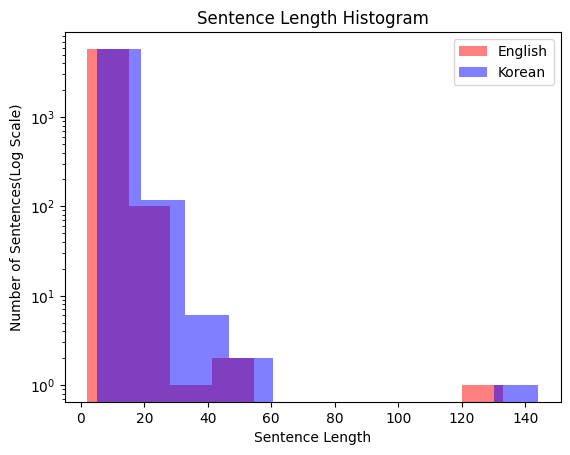

In [ ]:
# 인코딩된 길이 시각화
plt.hist(x=df_encode[source_lang].map(len), label=source_lang, alpha=0.5, color="r")
plt.hist(x=df_encode[target_lang].map(len), label=target_lang, alpha=0.5, color="b")
plt.title("Sentence Length Histogram")
plt.xlabel("Sentence Length")
plt.ylabel("Number of Sentences(Log Scale)")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
df_encode.map(len).max()

,0
English,133
Korean,144


In [ ]:
source_sequence_length = 20
target_sequence_length = 20
print(f"Number of {source_lang} lengths longer than {source_sequence_length}: {(df_encode[source_lang].map(len) > source_sequence_length).sum()}")
print(f"Number of {target_lang} lengths longer than {target_sequence_length}: {(df_encode[target_lang].map(len) > target_sequence_length).sum()}")

Number of English lengths longer than 20: 20
Number of Korean lengths longer than 20: 62


In [ ]:
source_tokenizer = open(f"./tf-sp-bpe-{source_lang}-nlp.model", "rb").read()
source_tokenizer = tf_text.SentencepieceTokenizer(model=source_tokenizer, out_type=tf.int32)
target_tokenizer = open(f"./tf-sp-bpe-{target_lang}-nlp.model", "rb").read()
target_tokenizer = tf_text.SentencepieceTokenizer(model=target_tokenizer, out_type=tf.int32)

# 모델

## 데이터셋 생성

In [ ]:
rate = 0.9
batch_size = 32

train_dataset, valid_dataset = make_dataset(dataset=df_encode,
                                            source_lang=source_lang,
                                            target_lang=target_lang,
                                            source_sequence_length=source_sequence_length,
                                            target_sequence_length=target_sequence_length,
                                            rate=rate,
                                            batch_size=batch_size)

In [ ]:
for (sou, tar0), tar1 in train_dataset.take(1):
    print(sou.shape)
    print(tar0.shape)
    print(tar1.shape)

(32, 20)
(32, 20)
(32, 20)


In [ ]:
for (sou, tar0), tar1 in train_dataset.take(1):
    print(tar0[0])
    print(tar1[0])

tf.Tensor(
[   2   22 1777 1186  345 1652   84  405   77 2089 2126 2058 2057    3
    0    0    0    0    0    0], shape=(20,), dtype=int32)
tf.Tensor(
[  22 1777 1186  345 1652   84  405   77 2089 2126 2058 2057    3    0
    0    0    0    0    0    0], shape=(20,), dtype=int32)


## 모델 아키텍처

In [ ]:
num_layers = 2
embed_dim = 256
dense_dim = 1024
num_heads = 8
dropout_rate = 0.1

model = Transformer(num_layers=num_layers, encoder_sequence_length=source_sequence_length, decoder_sequence_length=target_sequence_length,
                    source_vocab_size=source_vocab_size, target_vocab_size=target_vocab_size, embed_dim=embed_dim,
                 dense_dim=dense_dim, num_heads=num_heads, dropout_rate=dropout_rate)

## 모델 훈련

### 컴파일 옵션

In [ ]:
learning_rate = CustomSchedule(embed_dim=embed_dim)
optimizer = tf.keras.optimizers.Nadam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

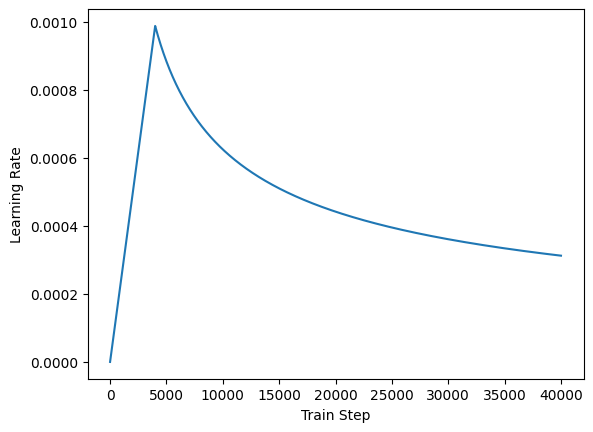

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [ ]:
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

### 훈련

In [ ]:
callbacks_list = [EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                patience=3, restore_best_weights=True),
                  TensorBoard(log_dir="/full_path_to_your_log_dir")]

history = model.fit(train_dataset, epochs=50, shuffle=True, validation_data=valid_dataset, callbacks=callbacks_list)

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - loss: 7.6144 - masked_accuracy: 0.1004 - val_loss: 5.9312 - val_masked_accuracy: 0.3039
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 5.6392 - masked_accuracy: 0.3199 - val_loss: 5.0624 - val_masked_accuracy: 0.3362
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 4.8651 - masked_accuracy: 0.3456 - val_loss: 4.6894 - val_masked_accuracy: 0.3583
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 4.4202 - masked_accuracy: 0.3744 - val_loss: 4.4310 - val_masked_accuracy: 0.3687
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 3.9925 - masked_accuracy: 0.4048 - val_loss: 4.1590 - val_masked_accuracy: 0.3899
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 3.5302 - masked_accuracy: 0.4474 - val_loss: 3.9318 - val_masked_accuracy: 0.4088
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 3.0555 - masked_accuracy: 0.4974 - val_loss: 3.7362 - val_masked_accuracy: 0.

In [ ]:
model.summary()

Model: "transformer_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_1 (Encoder)                  │ ?                           │       6,033,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_1 (Decoder)                  │ ?                           │      10,241,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 20, 3000)            │         771,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,137,834 (195.08 MB)

 Trainable params: 17,045,944 (65.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,091,890 (130.05 MB)

# 번역

In [ ]:
vocab_array = pd.read_csv(f'./tf-sp-bpe-{target_lang}-nlp.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)[0].values
vocab_tf = tf.constant(vocab_array, dtype=tf.string)

In [ ]:
translator = Translator(source_tokenizer=source_tokenizer, target_tokenizer=vocab_tf,
                        target_length=target_sequence_length, model=model)

In [ ]:
nums = list(range(len(df)))

for _ in range(10):
    print('-' * 20)
    n = random.choice(nums)
    random_text = df[source_lang][n]
    target_translate = translator(tf.constant(random_text, dtype=tf.string)).numpy().decode('utf-8').replace('▁', ' ').strip()
    real_text = df[target_lang][n]
    print(f"{source_lang}: {random_text}")
    print(f"Translated {target_lang}: {target_translate}")
    print(f"Real {target_lang}: {real_text}")
    print('-' * 20)

--------------------
English: tom has spent the past three years in prison.
Translated Korean: 톰은 과거 삼 년동안 감옥에 있었어.
Real Korean: <s> 톰은 과거 삼 년동안 감옥에 있었어. </s>
--------------------
--------------------
English: the concert lasted about three hours.
Translated Korean: 그 트리콥터 쓰고 있었어.
Real Korean: <s> 그 콘서트는 3시간 정도 걸렸다. </s>
--------------------
--------------------
English: tom met a friend of mary's at the airport.
Translated Korean: 톰은 메리의  메리와 함께가지로 만났어.
Real Korean: <s> 톰은 메리의 친구를 공항에서 만났다. </s>
--------------------
--------------------
English: i think tom is winning.
Translated Korean: 톰이 이기고 있는 것 같아.
Real Korean: <s> 톰이 이기고 있는 것 같다. </s>
--------------------
--------------------
English: you are shivering.
Translated Korean: 너 나하고 있어.
Real Korean: <s> 너 떨고 있네. </s>
--------------------
--------------------
English: he talks too fast.
Translated Korean: 그는 너무 빨리 말한다.
Real Korean: <s> 그는 너무 빨리 말한다. </s>
--------------------
--------------------
English: tom and mary have children.
Tr

In [ ]:
translator = Translator(source_tokenizer=source_tokenizer, target_tokenizer=vocab_tf,
                        target_length=target_sequence_length, model=model)

In [ ]:
translator(tf.constant("tom should have stayed in boston.", dtype=tf.string)).numpy().decode('utf-8').replace('▁', ' ').strip()

'톰은 보스턴에 오해 보인다고 말했다.'

In [ ]:
export_translator = ExportTranslator(translator)

In [ ]:
export_translator("tom should have stayed in boston.").numpy().decode('utf-8').replace('▁', ' ').strip()

'톰은 보스턴에 오해 보인다고 말했다.'

In [ ]:
tf.saved_model.save(export_translator, export_dir='./translator')

In [ ]:
reloaded = tf.saved_model.load("./translator")

In [ ]:
reloaded("tom should have stayed in boston.").numpy().decode('utf-8').replace('▁', ' ').strip()

'톰은 보스턴에 오해 보인다고 말했다.'